In [1]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
import pandas as pd
from tqdm import tqdm
from model_generator import Fluency
from model_coverage import KeywordCoverage
import argparse
from parameters import Parameters
import torch.optim as optim
from model_guardrails import PatternPenalty, LengthPenalty, RepeatPenalty, InvalidCharacter
import ast
import numpy as np
import time
import threading, queue
from transformers import GPT2LMHeadModel, BertForMaskedLM, AutoModel, GPT2Tokenizer

# batch_size = 2
# n_epochs = 1
# learning_rate = 2e-5

params = Parameters()

In [2]:
texts = ['PositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPositionPosition', 'This wonderful home has 7 bedrooms, 3 bathrooms, a three car garage, and is located near wonderful schools and local parks','Spacious 3 bedroom, 2 bathroom home with beautiful East River views and oversized balcony with direct access from both living room and primary bedroom. Large kitchen with pass-through to living room.']


In [2]:
# summarizer1 = Fluency(load_pretrained='fluency') # 3 epochs
summarizer2 = Fluency(load_pretrained='default')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded default fluency model, tokenizer


In [11]:
summarizer_gpt2.tokenizer.encode('<|endoftext|>')

[50256]

In [4]:
summarizer_gpt2 = Fluency()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded default fluency model, tokenizer


In [6]:
bos_token, eos_token, pad_token ='<|startoftext|>', '<|endoftext|>', '<|pad|>'
summarizer_gpt2.tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token=bos_token, eos_token=eos_token, pad_token=pad_token)
summarizer_gpt2.model = GPT2LMHeadModel.from_pretrained('gpt2').to('cuda')
summarizer_gpt2.model.resize_token_embeddings(len(summarizer_gpt2.tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Embedding(50259, 768)

In [8]:
x, y = summarizer_gpt2.preprocess_input(texts)

In [9]:
x

{'input_ids': tensor([[50257, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545,
         26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545,
         26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545,
         26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545],
        [50257,  1212,  7932,  1363,   468,   767, 38529,    11,   513, 32601,
            11,   257,  1115,  1097, 15591,    11,   290,   318,  5140,  1474,
          7932,  4266,   290,  1957, 14860, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258],
        [50257,  4561, 14209,   513, 14043,    11,   362, 12436,  1363,   351,
          4950,  3687,  5866,  5009,   290, 40931, 29780,   351,  1277,  1895,
           422,  1111,  2877,  2119,   290,  4165, 14043,    13, 13601,  9592,
           351,  1208,    12,  9579,   284,  2877,  2119,    13, 50258, 50258]],
       device='cuda:0'), 'attentio

In [12]:
y

{'input_ids': tensor([[26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545,
         26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545,
         26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545,
         26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 26545, 50256],
        [ 1212,  7932,  1363,   468,   767, 38529,    11,   513, 32601,    11,
           257,  1115,  1097, 15591,    11,   290,   318,  5140,  1474,  7932,
          4266,   290,  1957, 14860, 50256,    -1,    -1,    -1,    -1,    -1,
            -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1,    -1],
        [ 4561, 14209,   513, 14043,    11,   362, 12436,  1363,   351,  4950,
          3687,  5866,  5009,   290, 40931, 29780,   351,  1277,  1895,   422,
          1111,  2877,  2119,   290,  4165, 14043,    13, 13601,  9592,   351,
          1208,    12,  9579,   284,  2877,  2119,    13, 50256,    -1,    -1]],
       device='cuda:0'), 'attentio

In [3]:
summarizer3 = Fluency(load_pretrained='fluency') # 1 epoch
print(summarizer3.score(texts))

Loaded fine-tuned fluency model, tokenizer
tensor([0.9119, 0.7068, 0.6923], device='cuda:0')


In [3]:
texts = ["""A prewar Rosario Candela architectural masterpiece, this sun-flooded corner 14 into 11 room grand duplex was expertly renovated by renowned architect Mary Burnham of MBB Architects in partnership with designer Rachel Laxer and home builder Josh Weiner of Silver Lining. The largest home in the building, Apartment 10/11A has five bedrooms, five full bathrooms and two powder rooms. The residence has undergone a complete state-of-the-art restoration and modernization with every room being completely gutted and put back together with no expense being spared and utilizing the best of materials and systems while restoring the elegance of historic details. Perfect for both entertaining and everyday living, there are ceilings up to 10' 8", two wood burning fireplaces, a balcony, raised doorways, perfectly restored original oak wood flooring as well as new rift quarter sawn white oak flooring, new windows, custom millwork, plaster moldings, bespoke E.R. Butler & Co. hardware, specialty paint finishes, and radiant heat in the kitchen, mud room and all bathrooms. All mechanical elements of this sophisticated home have been fully modernized including new electrical, new plumbing and a state-of-the-art Savant Pro Home Technology system which integrates the extensive audio/video components, Lutron lighting system, motorized shades and HVAC. The Savant system allows you to control the entire home through your cell phone or the multiple iPads in the residence. There is a five-zone HVAC system with temperature controlled zones for AC and each room having a control for heat. The home has Cat5e cabling, a Panasonic phone and intercom system, wired WAPs throughout for excellent WiFi connectivity, in-ceiling speakers throughout and it is wired for televisions in seven rooms. A semi-private elevator landing opens onto a regal 31-foot long entrance gallery that spans the beautiful enfilade of formal spaces which face south, east and west. Off the gallery is an exquisite powder room, an oversized coat closet, and a discreet china closet hidden under the staircase. The sun-drenched living room boasts three oversized windows which face south. This magnificent room is 28' 7" by 20' 2" and has the first wood burning fireplace. Adjacent is a palatial 26-foot long corner library with four windows facing south and east which has been meticulously restored and has the original distinguished wood paneling, original Tudor style plaster molded ceiling and frieze, and the second wood burning fireplace. Next is a corner formal dining room which has been transformed into an incredible entertainment room which has four windows facing south and west and has a built-in banquette for dining. The corner eat-in kitchen is open to this room and can be closed off by concealed pocket doors if you want to formally entertain. The kitchen has custom Bulthaup cabinetry, quartzite countertops by Walker Zanger, porcelain tile flooring by Fibra Collection, and a center island clad in a Luce Di Luna slab with seating. It is equipped with top-of-the-line appliances including a Subzero refrigerator and two freezer drawers, a Subzero wine refrigerator, two Subzero refrigerator drawers, two Gaggenau ovens, a Gaggenau five burner range with a vented hood, a Gaggenau warming drawer, two Miele dishwashers, a Franke sink and an endless amount of storage. Off of the kitchen is an incredible large windowed mudroom with built-in wood storage lockers and shelving as well as a second windowed powder room, a balcony and a back staircase leading to the 11th floor.""",
            """Spacious 3 bedroom, 2 bathroom home with beautiful East River views and oversized balcony with direct access from both living room and primary bedroom. Large kitchen with pass-through to living room. Living room with plenty of room for dining, piano and more!
Primary bedroom is almost 400 sq ft and could accommodate a king sized bed, sitting room and home office. Closets are abundant and one walk-in could easily convert to 3rd bathroom or laundry room.
Two additional bedrooms could also accommodate king sized beds, desks etc. 
W/D allowed. Cats & Dog friendly. 45 East End Ave permits up to 65% Financing."""]
toks = summarizer.tokenizer(texts, truncation=True, max_length=510)
out_samp = summarizer.decode_batch(texts, sample=True)
print(out_samp)

This prewar Rosario Candela architectural masterpiece, this sun-flooded corner 14 into 11 room grand duplex<|endoftext|>
Wowacious 3 bedroom 2 bathrooms kit, bedroom, bedroom, a living room apartment and room room<|endoftext|> <|pad|>  access access to access
(['This prewar Rosario Candela architectural masterpiece, this sun-flooded corner 14 into 11 room grand duplex', 'Wowacious 3 bedroom 2 bathrooms kit, bedroom, bedroom, a living room apartment and room room'], [24, 19])


In [4]:
out_max = summarizer.decode_batch(texts, sample=False)
print(out_max)

This prewar Rosario Candela architectural masterpiece, this sun-flooded corner 14 into 11 room grand duplex<|endoftext|> <|startoftext|> This
Thisacious 3 bedroom bedroom bedroom home with beautiful East River views and direct access from both both living room room room room room and room<|endoftext|>
(['This prewar Rosario Candela architectural masterpiece, this sun-flooded corner 14 into 11 room grand duplex', 'Thisacious 3 bedroom bedroom bedroom home with beautiful East River views and direct access from both both living room room room room room and room'], [24, 26])


In [ ]:
out_max

In [18]:
def score(sampled_summs, argmax_summs, sampled_lens, argmax_lens, contents, locs, scorers, prebuild_withouts, prebuild_summaries, is_train=True, i_epoch=-1):
    sampled = {}
    argmax = {}
    N = len(sampled_summs)
    
    importance, model = scorers['coverage']['importance'], scorers['coverage']['model']
    sampled_acc, acc_wo = model.score(sampled_summs, contents, locs, prebuild_withouts=prebuild_withouts, prebuild_summaries=prebuild_summaries)
    argmax_acc, _ = model.score(argmax_summs, contents, locs, accs_without=acc_wo)
    sampled['coverage'] = importance * sampled_acc
    argmax['coverage'] = importance * argmax_acc

    importance, model = scorers['fluency']['importance'], scorers['fluency']['model']
    sampled['fluency'] = importance * model.score(sampled_summs)
    argmax['fluency'] = importance * model.score(argmax_summs)

    importance, model = scorers['patpen']['importance'], scorers['patpen']['model']
    sampled['patpen'] = importance * model.score(sampled_summs)
    argmax['patpen'] = importance * model.score(argmax_summs)

    importance, model = scorers['lengthpen']['importance'], scorers['lengthpen']['model']
    sampled['lengthpen'] = importance * model.score(sampled_lens, sampled_lens)
    argmax['lengthpen'] = importance * model.score(argmax_lens, argmax_lens)

    importance, model = scorers['reppen']['importance'], scorers['reppen']['model']
    sampled['reppen'] = importance * model.score(sampled_summs)
    argmax['reppen'] = importance * model.score(argmax_summs)
    
    importance, model = scorers['badchar']['importance'], scorers['badchar']['model']
    sampled['badchar'] = importance * model.score(sampled_summs)
    argmax['badchar'] = importance * model.score(argmax_summs)

    sampled_scores, argmax_scores = 0, 0
    for _model in ['coverage','fluency','patpen','lengthpen','reppen','badchar']:
        sampled_scores += sampled[_model]
        argmax_scores += argmax[_model]
    sampled_scores = sampled_scores.to('cuda')
    argmax_scores = argmax_scores.to('cuda')
    
    sampled = {key:(val / scorers[key]['importance']).sum().item() for key,val in sampled.items()}
    argmax = {key:(val / scorers[key]['importance']).sum().item() for key,val in argmax.items()}
    sampled['sampled'] = True
    argmax['sampled'] = False
    sampled['is_train'] = is_train
    argmax['is_train'] = is_train
    sampled['epoch'] = i_epoch
    argmax['epoch'] = i_epoch
    sampled['batch_size'] = N
    argmax['batch_size'] =  N
    
    # sampled_rows = [dict(zip(sampled,t)) for t in zip(*sampled.values())]
    # argmax_rows = [dict(zip(argmax,t)) for t in zip(*argmax.values())]

    return sampled_scores, argmax_scores, sampled, argmax

In [2]:
summarizer = Fluency(load_pretrained='summarizer')
summarizer.model.to(summarizer.device)

param_optimizer = list(summarizer.model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)
optim_every = int(5)
scheduler = None

scorers = {}
scorers['coverage'] = {'importance':10.0, 'model':KeywordCoverage(_type='coverage')}
scorers['fluency'] = {'importance':10.0, 'model':Fluency(load_pretrained='fluency')}
scorers['patpen'] = {'importance':5.0, 'model':PatternPenalty()}
scorers['lengthpen'] = {'importance':2.0, 'model':LengthPenalty(params.max_output_length)}
scorers['reppen'] = {'importance':2.0, 'model':RepeatPenalty()}
scorers['badchar'] = {'importance':2.0, 'model':InvalidCharacter()}

Loaded pretrained summarizer model, tokenizer


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Loaded fine-tuned coverage model, tokenizer
Loaded fine-tuned fluency model, tokenizer


In [6]:
texts = ['This is a sentence, it is very long, I like this sentence','Penis cock']
toks = summarizer.tokenizer(texts, return_tensors='pt', padding=True).to('cuda')
z = summarizer.model(**toks)

In [3]:
df = pd.read_csv(params.dataset_filename, low_memory=False)
# descs = []
# locs = []
# for i,(desc,loc) in enumerate(zip(df.desc_clean, df.desc_clean_msg_stripped_locs)):
#     if isinstance(desc,str) and isinstance(loc,str) and isinstance(ast.literal_eval(loc), list):
#         descs.append(' '.join(desc.split(' ')[:500]))
#         locs.append(ast.literal_eval(loc))

# def collate_func(batch):
#     # descs, locs = [item[0] for item in batch], [item[1] for item in batch]
#     # return descs, locs
#     return list(zip(*batch))

# dataset = list(zip(descs, locs))
# N = len(dataset)
# N_train = int(N * 0.8)
# N_val = N - N_train
# d_train, d_val = torch.utils.data.dataset.random_split(dataset, [N_train, N_val])
# dl_train = DataLoader(dataset=d_train, batch_size=batch_size, drop_last=True, shuffle=True, collate_fn=collate_func)
# dl_val = DataLoader(dataset=d_val, batch_size=batch_size, drop_last=True, shuffle=True, collate_fn=collate_func)

# prebuild_withouts_queue = queue.Queue()
# prebuild_summaries_queue = queue.Queue()
# def background_worker(descs, msgs, locs, q):
#     q.put(scorers['coverage']['model'].build_inputs(descs, msgs, locs))
    
# scaler = torch.cuda.amp.GradScaler()


In [15]:
good_idxs = [isinstance(msg,str) and isinstance(clicks,float) and clicks>0 for msg,clicks in zip(df.msg_clean, df.clicks)]
good_idxs = df.index[good_idxs]
lens_tokens = [len(tok.encode(x)) for x in df.msg[good_idxs].tolist()]
lens_words = [len(x.split(' ')) for x in df.msg[good_idxs].tolist()]
import numpy as np
clicks = np.asarray(df.clicks[good_idxs])
rel_clicks = clicks / np.sum(clicks)
unique_lens_toks = np.asarray(list(set(lens_tokens)))
buckets_toks = np.zeros(len(unique_lens_toks))
unique_lens_words = np.asarray(list(set(lens_words)))
buckets_words = np.zeros(len(unique_lens_words))
for n_words,n_toks,clicks in zip(lens_words, lens_tokens, rel_clicks):
    bucket_idx = np.argwhere(unique_lens_toks == n_toks)[0][0]
    buckets_toks[bucket_idx] += clicks
    bucket_idx = np.argwhere(unique_lens_words == n_words)[0][0]
    buckets_words[bucket_idx] += clicks

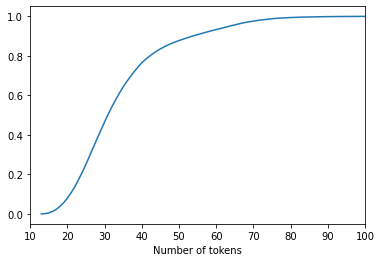

In [18]:
import matplotlib.pyplot as plt
plt.plot(unique_lens_toks, np.cumsum(buckets_toks), label='# tokens')
# plt.plot(unique_lens_words, np.cumsum(buckets_words), label='# words')
plt.xlim((10,100))
# plt.legend()
plt.xlabel('Number of tokens')
plt.show()

In [31]:
np.cumsum(buckets_toks)[np.argwhere((unique_lens_toks >=20) * (unique_lens_toks <=40)).flatten()]

array([0.08002325, 0.10683662, 0.1380186 , 0.17375874, 0.21074429,
       0.25143918, 0.29509217, 0.33805295, 0.38178395, 0.42304605,
       0.4653884 , 0.50569848, 0.54397648, 0.57810283, 0.61170469,
       0.64279104, 0.67039726, 0.69627823, 0.72045247, 0.74375068,
       0.76449362])

In [23]:
np.argwhere((unique_lens_toks >=20) * (unique_lens_toks <=40))[0]

array([7], dtype=int64)

In [30]:
np.argwhere((unique_lens_toks >=20) * (unique_lens_toks <=40)).flatten()

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27], dtype=int64)

In [4]:
good_idxs = [isinstance(msg,str) and isinstance(clicks,float) and clicks>0 for msg,clicks in zip(df.msg_clean, df.clicks)]
good_idxs = df.index[good_idxs]
lens = [len(x.split(' ')) for x in df.msg[good_idxs].tolist()]
import numpy as np
clicks = np.asarray(df.clicks[good_idxs])
rel_clicks = clicks / np.sum(clicks)
unique_lens = np.asarray(list(set(lens)))
buckets = np.zeros(len(unique_lens))
for length,clicks in zip(lens, rel_clicks):
    bucket_idx = np.argwhere(unique_lens == length)[0][0]
    buckets[bucket_idx] += clicks

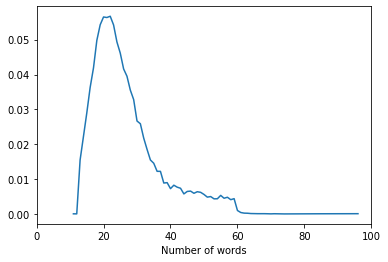

In [5]:
import matplotlib.pyplot as plt
plt.plot(unique_lens, buckets)
plt.xlim((0,100))
plt.xlabel('Number of words')
plt.show()

In [19]:
# def decode_batch(bodies, input_past=None, sample=False, return_logprobs=False):
#     N = len(bodies)
#     current = summarizer.tokenizer([summarizer.tokenizer.bos_token] * N, return_tensors='pt').input_ids.to(summarizer.device)
#     build_up = None
#     total_logprobs = []
#     with torch.no_grad():
#         if input_past is None:
#             inputs = summarizer.tokenizer(bodies, return_tensors='pt', padding=True, truncation=True, max_length=summarizer.max_input_length).to(summarizer.device)
#             input_past = summarizer.model(**inputs)
#         past = input_past.past_key_values

#     while build_up is None or (build_up.shape[1] < summarizer.max_output_length and not all([summarizer.tokenizer.eos_token_id in build for build in build_up])):
#         outputs = summarizer.model(current, past_key_values=past)
#         logits = outputs.logits
#         past = outputs.past_key_values
#         probs = torch.nn.functional.softmax(logits, dim=2).squeeze(1)
#         logprobs = torch.nn.functional.log_softmax(logits, dim=2)
#         if sample:
#             current = torch.multinomial(probs, 1)
#         else:
#             current = torch.argmax(logprobs, dim=2)

#         if build_up is None:
#             build_up = current
#         else:
#             build_up = torch.cat((build_up, current), dim=1)

#         if return_logprobs:
#             print(logprobs.shape, current.squeeze().tolist())
#             selected_logprobs = logprobs[:, 0, current.squeeze()].unsqueeze(1)
#             total_logprobs.append(selected_logprobs)

#     build_up = [[token for token in build if not token in summarizer.special_token_ids] for build in build_up]
#     end_idxs = [summarizer.max_output_length+1 if summarizer.tokenizer.eos_token_id not in build else build.index(summarizer.tokenizer.eos_token_id) for build in build_up]
#     outputs = [summarizer.tokenizer.decode(build) for build in build_up]
#     # outputs = [output[:idx] for output,idx in zip(outputs, end_idxs)]
#     if return_logprobs:
#         return outputs, torch.cat(total_logprobs, dim=1), input_past, end_idxs
#     else:
#         return outputs, end_idxs

In [20]:
# for ib, batch in enumerate(dl_train):
#     with torch.cuda.amp.autocast() and torch.no_grad():
#         descs, locs = batch
#         sampled_summaries, sampled_logprobs, input_past, sampled_end_idxs = decode_batch(descs, return_logprobs=True, sample=True) # 32%
#     break

In [13]:
sampled_logprobs.max()

tensor(-2.3842e-07, device='cuda:0')

In [19]:
rows = []
for i_epoch in range(n_epochs):
    total_train_score = 0.0
    total_val_score = 0.0
    summarizer.model.train()
    for ib, batch in enumerate(tqdm(dl_train, desc='Train, epoch #{} - LR={}'.format(i_epoch, optimizer.param_groups[0]["lr"]))):
        with torch.cuda.amp.autocast():
            descs, locs = batch
            prebuild_withouts_thread = threading.Thread(target=background_worker, args=(descs, [""] * len(descs), locs, prebuild_withouts_queue))
            prebuild_withouts_thread.start()
            
            sampled_summaries, sampled_logprobs, input_past, sampled_end_idxs = summarizer.decode_batch(descs, return_logprobs=True, sample=True) # 32%
            prebuild_summaries_thread = threading.Thread(target=background_worker, args=(descs, sampled_summaries, locs, prebuild_summaries_queue))
            prebuild_summaries_thread.start()
            selected_logprobs = torch.sum(sampled_logprobs, dim=1)
            del sampled_logprobs
            argmax_summaries, argmax_end_idxs = summarizer.decode_batch(descs, input_past=input_past) # 18%
            del input_past
            prebuild_withouts_thread.join()
            prebuild_summaries_thread.join()
            prebuild_withouts = prebuild_withouts_queue.get()
            prebuild_summaries = prebuild_summaries_queue.get()

            
            total_sampled_scores, total_argmax_scores, sampled_dict, argmax_dict = score(sampled_summaries, argmax_summaries, sampled_end_idxs, argmax_end_idxs, descs, locs, scorers, 
                                                                prebuild_withouts, prebuild_summaries, is_train=True) # 15%
            rows += new_rows
            del prebuild_withouts, prebuild_summaries
            # sum_diff += float((total_argmax_scores - total_sampled_scores).sum())
            loss = torch.mean((total_argmax_scores - total_sampled_scores) * selected_logprobs)
            del selected_logprobs, total_sampled_scores, total_argmax_scores
            scaler.scale(loss).backward() # 25%
            total_train_score += float(loss)
            del loss
        if ib+1 % optim_every == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            break
    break

#     avg_train_score = total_train_score / (len(d_train) * batch_size)
#     summarizer.model.eval()
#     with torch.no_grad():
#         for ib, batch in enumerate(tqdm(dl_val, desc='Val, epoch #{} - LR={}'.format(i_epoch, optimizer.param_groups[0]["lr"]))):
#             descs, locs = batch
#             prebuild_withouts_thread = threading.Thread(target=background_worker, args=(descs, [""] * len(descs), locs, prebuild_withouts_queue))
#             prebuild_withouts_thread.start()

#             sampled_summaries, sampled_logprobs, input_past, sampled_end_idxs = summarizer.decode_batch(descs, return_logprobs=True, sample=True)
#             prebuild_summaries_thread = threading.Thread(target=background_worker, args=(descs, sampled_summaries, locs, prebuild_summaries_queue))
#             prebuild_summaries_thread.start()

#             selected_logprobs = torch.sum(sampled_logprobs, dim=1)
#             del sampled_logprobs
#             argmax_summaries, argmax_end_idxs = summarizer.decode_batch(descs, input_past=input_past)
#             del input_past
#             prebuild_withouts_thread.join()
#             prebuild_summaries_thread.join()
#             prebuild_withouts = prebuild_withouts_queue.get()
#             prebuild_summaries = prebuild_summaries_queue.get()
#             total_sampled_scores, total_argmax_scores = score(sampled_summaries, argmax_summaries, sampled_end_idxs, argmax_end_idxs, descs, locs, scorers, 
#                                                                 prebuild_withouts, prebuild_summaries)
#             del prebuild_withouts, prebuild_summaries
#             loss = float(torch.mean((total_argmax_scores - total_sampled_scores) * selected_logprobs))
#             del selected_logprobs, total_sampled_scores, total_argmax_scores
#             total_val_score += loss

#     avg_val_score = total_val_score / (len(d_val) * batch_size)

#     if scheduler is not None:
#         scheduler.step()
#     with open('summary_scores.csv','a') as f:
#         line = '\n' + str(avg_train_score) + ',' + str(avg_val_score)
#         print(line)
#         f.write(line)
        

#     texts = ["""A prewar Rosario Candela architectural masterpiece, this sun-flooded corner 14 into 11 room grand duplex was expertly renovated by renowned architect Mary Burnham of MBB Architects in partnership with designer Rachel Laxer and home builder Josh Weiner of Silver Lining. The largest home in the building, Apartment 10/11A has five bedrooms, five full bathrooms and two powder rooms. The residence has undergone a complete state-of-the-art restoration and modernization with every room being completely gutted and put back together with no expense being spared and utilizing the best of materials and systems while restoring the elegance of historic details. Perfect for both entertaining and everyday living, there are ceilings up to 10' 8", two wood burning fireplaces, a balcony, raised doorways, perfectly restored original oak wood flooring as well as new rift quarter sawn white oak flooring, new windows, custom millwork, plaster moldings, bespoke E.R. Butler & Co. hardware, specialty paint finishes, and radiant heat in the kitchen, mud room and all bathrooms. All mechanical elements of this sophisticated home have been fully modernized including new electrical, new plumbing and a state-of-the-art Savant Pro Home Technology system which integrates the extensive audio/video components, Lutron lighting system, motorized shades and HVAC. The Savant system allows you to control the entire home through your cell phone or the multiple iPads in the residence. There is a five-zone HVAC system with temperature controlled zones for AC and each room having a control for heat. The home has Cat5e cabling, a Panasonic phone and intercom system, wired WAPs throughout for excellent WiFi connectivity, in-ceiling speakers throughout and it is wired for televisions in seven rooms. A semi-private elevator landing opens onto a regal 31-foot long entrance gallery that spans the beautiful enfilade of formal spaces which face south, east and west. Off the gallery is an exquisite powder room, an oversized coat closet, and a discreet china closet hidden under the staircase. The sun-drenched living room boasts three oversized windows which face south. This magnificent room is 28' 7" by 20' 2" and has the first wood burning fireplace. Adjacent is a palatial 26-foot long corner library with four windows facing south and east which has been meticulously restored and has the original distinguished wood paneling, original Tudor style plaster molded ceiling and frieze, and the second wood burning fireplace. Next is a corner formal dining room which has been transformed into an incredible entertainment room which has four windows facing south and west and has a built-in banquette for dining. The corner eat-in kitchen is open to this room and can be closed off by concealed pocket doors if you want to formally entertain. The kitchen has custom Bulthaup cabinetry, quartzite countertops by Walker Zanger, porcelain tile flooring by Fibra Collection, and a center island clad in a Luce Di Luna slab with seating. It is equipped with top-of-the-line appliances including a Subzero refrigerator and two freezer drawers, a Subzero wine refrigerator, two Subzero refrigerator drawers, two Gaggenau ovens, a Gaggenau five burner range with a vented hood, a Gaggenau warming drawer, two Miele dishwashers, a Franke sink and an endless amount of storage. Off of the kitchen is an incredible large windowed mudroom with built-in wood storage lockers and shelving as well as a second windowed powder room, a balcony and a back staircase leading to the 11th floor.""",
#             """Spacious 3 bedroom, 2 bathroom home with beautiful East River views and oversized balcony with direct access from both living room and primary bedroom. Large kitchen with pass-through to living room. Living room with plenty of room for dining, piano and more!
# Primary bedroom is almost 400 sq ft and could accommodate a king sized bed, sitting room and home office. Closets are abundant and one walk-in could easily convert to 3rd bathroom or laundry room.
# Two additional bedrooms could also accommodate king sized beds, desks etc. 
# W/D allowed. Cats & Dog friendly. 45 East End Ave permits up to 65% Financing.

# 45 East End Avenue was built in 1951 by acclaimed New York City architect firm Emery Roth & Sons. The building has full-time doorman, live-in resident manager, laundry room, roof deck, parking garage, storage & bike room.
# Perched over the promenade, 45 East End shareholders enjoy easy access to the outdoors; the John Finley Walkway, the Carl Schurz dog run, the 90th St Ferry Terminal, allowing for an easy commute for Downtown workers and very close to the 83rd Street entrance to the Second Avenue Subway. 
# The co-op boasts strong financials while also completing a number of capital projects."""]
#     with torch.no_grad():
#         sampled_summaries, _ = summarizer.decode_batch(texts, sample=True)
#         sampled_summaries = [x.replace('\n','\\n') for x in sampled_summaries]
#         print('**SAMPLED**\n** '+'\n** '.join(sampled_summaries))
#         argmax_summaries, _ = summarizer.decode_batch(texts)
#         argmax_summaries = [x.replace('\n', '\\n') for x in argmax_summaries]
#         print('**ARGMAX**\n** '+'\n** '.join(argmax_summaries))
    
#     summarizer.model.save_pretrained(params.summary_loop_model_dir)

Train, epoch #0 - LR=2e-05:   0%|          | 0/19690 [00:01<?, ?it/s]


NameError: name 'new_rows' is not defined

In [20]:
sampled_dict

{'coverage': 0.0,
 'fluency': 0.3549717962741852,
 'patpen': 2.0,
 'lengthpen': 2.0,
 'reppen': 2.0,
 'badchar': 1.0,
 'sampled': True,
 'is_train': True,
 'epoch': -1,
 'batch_size': 2}

In [21]:
argmax_dict

{'coverage': 0.0,
 'fluency': 1.4563519954681396,
 'patpen': 2.0,
 'lengthpen': 2.0,
 'reppen': 2.0,
 'badchar': 0.0,
 'sampled': False,
 'is_train': True,
 'epoch': -1,
 'batch_size': 2}